# ResNet Quantization Performance Comparison

This notebook compares the performance of ResNet models after various quantization techniques across multiple datasets:
- **CIFAR-100**: 100 classes of 32x32 images
- **Food-101**: 101 food categories
- **Fashion-MNIST**: 10 clothing categories
- **Stanford Cars**: 196 car classes

## Quantization Methods Compared:
1. **Baseline (FP32)**: Full precision model
2. **Dynamic Quantization**: Quantizes weights to INT8, activations computed at runtime
3. **Static Quantization (PTQ)**: Post-training quantization with calibration
4. **Quantization-Aware Training (QAT)**: Training with simulated quantization

## 1. Setup and Installation

In [6]:
# Install required packages
%pip install torch torchvision tqdm matplotlib pandas seaborn scikit-learn numpy

  Using cached torch-2.9.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached torchvision-0.24.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-manylinux201

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization as quantization
from torch.quantization import get_default_qconfig, prepare, convert
from torch.ao.quantization import get_default_qat_qconfig, prepare_qat
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu
PyTorch version: 2.9.1+cpu


## 2. Configuration

In [9]:
# Configuration
CONFIG = {
    'batch_size': 64,
    'num_workers': 4,
    'learning_rate': 0.001,
    'num_epochs': 10,  # For fine-tuning
    'qat_epochs': 5,   # For quantization-aware training
    'data_dir': './data',
    'model_dir': './models',
    'seed': 42,
}

# Dataset configurations
DATASETS = {
    'cifar100': {
        'num_classes': 100,
        'input_size': 224,  # ResNet expects 224x224
        'mean': (0.5071, 0.4867, 0.4408),
        'std': (0.2675, 0.2565, 0.2761),
    },
    'food101': {
        'num_classes': 101,
        'input_size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225),
    },
    'fashion_mnist': {
        'num_classes': 10,
        'input_size': 224,
        'mean': (0.2860,),
        'std': (0.3530,),
    },
    'stanford_cars': {
        'num_classes': 196,
        'input_size': 224,
        'mean': (0.485, 0.456, 0.406),
        'std': (0.229, 0.224, 0.225),
    },
}

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create directories
os.makedirs(CONFIG['data_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)

## 3. Dataset Loading Functions

In [10]:
def get_transforms(dataset_name, is_train=True):
    """Get transforms for each dataset."""
    config = DATASETS[dataset_name]
    input_size = config['input_size']
    mean = config['mean']
    std = config['std']

    # Fashion MNIST is grayscale, needs special handling
    if dataset_name == 'fashion_mnist':
        if is_train:
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(mean * 3, std * 3),  # Repeat for 3 channels
            ])
        else:
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean * 3, std * 3),
            ])
    else:
        if is_train:
            transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ])

    return transform


def load_dataset(dataset_name, subset_size=None):
    """Load dataset with train/val/test splits."""
    data_dir = CONFIG['data_dir']

    train_transform = get_transforms(dataset_name, is_train=True)
    test_transform = get_transforms(dataset_name, is_train=False)

    if dataset_name == 'cifar100':
        train_dataset = torchvision.datasets.CIFAR100(
            root=data_dir, train=True, download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.CIFAR100(
            root=data_dir, train=False, download=True, transform=test_transform
        )
        # Create calibration set from training data
        calib_dataset = torchvision.datasets.CIFAR100(
            root=data_dir, train=True, download=False, transform=test_transform
        )

    elif dataset_name == 'food101':
        train_dataset = torchvision.datasets.Food101(
            root=data_dir, split='train', download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.Food101(
            root=data_dir, split='test', download=True, transform=test_transform
        )
        calib_dataset = torchvision.datasets.Food101(
            root=data_dir, split='train', download=False, transform=test_transform
        )

    elif dataset_name == 'fashion_mnist':
        train_dataset = torchvision.datasets.FashionMNIST(
            root=data_dir, train=True, download=True, transform=train_transform
        )
        test_dataset = torchvision.datasets.FashionMNIST(
            root=data_dir, train=False, download=True, transform=test_transform
        )
        calib_dataset = torchvision.datasets.FashionMNIST(
            root=data_dir, train=True, download=False, transform=test_transform
        )

    elif dataset_name == 'stanford_cars':
        # Stanford Cars dataset
        try:
            train_dataset = torchvision.datasets.StanfordCars(
                root=data_dir, split='train', download=True, transform=train_transform
            )
            test_dataset = torchvision.datasets.StanfordCars(
                root=data_dir, split='test', download=True, transform=test_transform
            )
            calib_dataset = torchvision.datasets.StanfordCars(
                root=data_dir, split='train', download=False, transform=test_transform
            )
        except Exception as e:
            print(f"Stanford Cars download may have issues. Error: {e}")
            print("You may need to download it manually from Kaggle.")
            return None, None, None

    # Optionally use subset for faster experimentation
    if subset_size is not None:
        train_indices = np.random.choice(len(train_dataset), min(subset_size, len(train_dataset)), replace=False)
        test_indices = np.random.choice(len(test_dataset), min(subset_size // 5, len(test_dataset)), replace=False)
        calib_indices = np.random.choice(len(calib_dataset), min(1000, len(calib_dataset)), replace=False)

        train_dataset = Subset(train_dataset, train_indices)
        test_dataset = Subset(test_dataset, test_indices)
        calib_dataset = Subset(calib_dataset, calib_indices)
    else:
        # Use subset for calibration anyway (1000 samples is usually enough)
        calib_indices = np.random.choice(len(calib_dataset), min(1000, len(calib_dataset)), replace=False)
        calib_dataset = Subset(calib_dataset, calib_indices)

    return train_dataset, test_dataset, calib_dataset


def get_dataloaders(dataset_name, subset_size=None):
    """Create dataloaders for train, test, and calibration."""
    train_dataset, test_dataset, calib_dataset = load_dataset(dataset_name, subset_size)

    if train_dataset is None:
        return None, None, None

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )
    calib_loader = DataLoader(
        calib_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True
    )

    print(f"Dataset: {dataset_name}")
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Calibration samples: {len(calib_dataset)}")

    return train_loader, test_loader, calib_loader

## 4. Model Creation and Fine-tuning

In [11]:
def create_resnet_model(num_classes, pretrained=True, model_name='resnet18'):
    """Create a ResNet model with modified classifier for the target dataset."""

    if model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    elif model_name == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Modify the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model


def create_quantizable_resnet(num_classes, pretrained=True, model_name='resnet18'):
    """Create a quantization-ready ResNet model."""

    # Use quantizable ResNet variants
    if model_name == 'resnet18':
        model = models.quantization.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None,
            quantize=False
        )
    elif model_name == 'resnet50':
        model = models.quantization.resnet50(
            weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None,
            quantize=False
        )
    else:
        # Fall back to regular model for unsupported variants
        return create_resnet_model(num_classes, pretrained, model_name)

    # Modify the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

In [12]:
def train_model(model, train_loader, test_loader, num_epochs, device, lr=0.001):
    """Train or fine-tune a model."""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = 100. * correct / total

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, '
              f'Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%')

    return model, history


def train_qat_model(model, train_loader, test_loader, num_epochs, device):
    """Train a model with Quantization-Aware Training."""
    # Prepare model for QAT
    model.train()
    model = model.to('cpu')  # QAT works on CPU

    # Fuse modules
    model.fuse_model()

    # Set QAT configuration
    model.qconfig = get_default_qat_qconfig('fbgemm')
    prepare_qat(model, inplace=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'] * 0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'QAT Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            # QAT training on CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = 100. * correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'QAT Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%')

    # Convert to quantized model
    model.eval()
    quantized_model = convert(model, inplace=False)

    return quantized_model, history

## 5. Quantization Functions

In [13]:
def apply_dynamic_quantization(model):
    """Apply dynamic quantization to the model."""
    model_cpu = copy.deepcopy(model).cpu()
    model_cpu.eval()

    # Dynamic quantization - quantizes weights, computes activations in float
    quantized_model = torch.quantization.quantize_dynamic(
        model_cpu,
        {nn.Linear, nn.Conv2d},  # Layers to quantize
        dtype=torch.qint8
    )

    return quantized_model


def apply_static_quantization(model, calib_loader, num_classes):
    """Apply static (post-training) quantization with calibration."""
    # Use quantizable model
    model_quant = create_quantizable_resnet(num_classes, pretrained=False)
    model_quant.load_state_dict(model.state_dict(), strict=False)
    model_quant.eval()

    # Fuse modules (Conv+BN+ReLU)
    model_quant.fuse_model()

    # Set quantization configuration
    model_quant.qconfig = get_default_qconfig('fbgemm')

    # Prepare for quantization
    prepare(model_quant, inplace=True)

    # Calibrate with representative data
    print("Calibrating model...")
    with torch.no_grad():
        for inputs, _ in tqdm(calib_loader, desc="Calibration"):
            model_quant(inputs)

    # Convert to quantized model
    quantized_model = convert(model_quant, inplace=False)

    return quantized_model


def apply_static_quantization_simple(model, calib_loader):
    """Simplified static quantization for regular ResNet models."""
    model_cpu = copy.deepcopy(model).cpu()
    model_cpu.eval()

    # Quantization config
    model_cpu.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare model
    model_prepared = torch.quantization.prepare(model_cpu, inplace=False)

    # Calibrate
    print("Calibrating model...")
    with torch.no_grad():
        for inputs, _ in tqdm(calib_loader, desc="Calibration"):
            try:
                model_prepared(inputs)
            except Exception as e:
                pass  # Some layers may not support quantization

    # Convert
    try:
        quantized_model = torch.quantization.convert(model_prepared, inplace=False)
        return quantized_model
    except Exception as e:
        print(f"Static quantization failed: {e}")
        print("Falling back to dynamic quantization")
        return apply_dynamic_quantization(model)

## 6. Benchmarking and Evaluation

In [18]:
def get_model_size(model):
    """Get model size in MB."""
    torch.save(model.state_dict(), "temp_model.pt")
    size_mb = os.path.getsize("temp_model.pt") / (1024 * 1024)
    os.remove("temp_model.pt")
    return size_mb


def count_parameters(model):
    """Count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate model accuracy and get predictions."""
    if isinstance(device, str):
        device = torch.device(device)
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels


def measure_inference_time(model, test_loader, device='cpu', num_batches=50):
    """Measure average inference time per batch."""
    if isinstance(device, str):
        device = torch.device(device)
    model = model.to(device)
    model.eval()

    # Warmup
    warmup_input = next(iter(test_loader))[0].to(device)
    for _ in range(10):
        with torch.no_grad():
            _ = model(warmup_input)

    # Measure
    times = []
    batch_count = 0

    with torch.no_grad():
        for inputs, _ in test_loader:
            if batch_count >= num_batches:
                break

            inputs = inputs.to(device)

            if device.type == 'cuda':
                torch.cuda.synchronize()

            start = time.perf_counter()
            _ = model(inputs)

            if device.type == 'cuda':
                torch.cuda.synchronize()

            end = time.perf_counter()
            times.append(end - start)
            batch_count += 1

    avg_time = np.mean(times) * 1000  # Convert to ms
    std_time = np.std(times) * 1000

    return avg_time, std_time


def benchmark_model(model, test_loader, model_name, device='cpu'):
    """Complete benchmark of a model."""
    if isinstance(device, str):
        device = torch.device(device)

    print(f"\nBenchmarking: {model_name}")
    print("-" * 50)

    # Model size
    size_mb = get_model_size(model)
    print(f"Model size: {size_mb:.2f} MB")

    # Accuracy
    accuracy, preds, labels = evaluate_model(model, test_loader, device)
    print(f"Accuracy: {accuracy:.2f}%")

    # Inference time (always on CPU for fair comparison of quantized models)
    avg_time, std_time = measure_inference_time(model, test_loader, device=torch.device('cpu'))
    print(f"Inference time: {avg_time:.2f} ± {std_time:.2f} ms/batch")

    results = {
        'model_name': model_name,
        'size_mb': size_mb,
        'accuracy': accuracy,
        'inference_time_ms': avg_time,
        'inference_std_ms': std_time,
    }

    return results, preds, labels

## 7. Visualization Functions

In [15]:
def plot_training_history(history, title="Training History"):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


def plot_comparison_results(results_df, dataset_name):
    """Plot comparison of different quantization methods."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    colors = sns.color_palette("husl", len(results_df))

    # Accuracy comparison
    bars1 = axes[0].bar(results_df['model_name'], results_df['accuracy'], color=colors)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title(f'{dataset_name} - Accuracy Comparison')
    axes[0].tick_params(axis='x', rotation=45)
    for bar, val in zip(bars1, results_df['accuracy']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

    # Model size comparison
    bars2 = axes[1].bar(results_df['model_name'], results_df['size_mb'], color=colors)
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Size (MB)')
    axes[1].set_title(f'{dataset_name} - Model Size Comparison')
    axes[1].tick_params(axis='x', rotation=45)
    for bar, val in zip(bars2, results_df['size_mb']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{val:.1f}', ha='center', va='bottom', fontsize=9)

    # Inference time comparison
    bars3 = axes[2].bar(results_df['model_name'], results_df['inference_time_ms'],
                        yerr=results_df['inference_std_ms'], color=colors, capsize=5)
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Time (ms/batch)')
    axes[2].set_title(f'{dataset_name} - Inference Time Comparison')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(f'{CONFIG["model_dir"]}/{dataset_name}_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_all_datasets_comparison(all_results):
    """Plot comparison across all datasets."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    # Accuracy heatmap
    accuracy_data = {}
    for dataset, results in all_results.items():
        accuracy_data[dataset] = {r['model_name']: r['accuracy'] for r in results}

    accuracy_df = pd.DataFrame(accuracy_data)

    sns.heatmap(accuracy_df, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0])
    axes[0].set_title('Accuracy (%) Across Datasets and Quantization Methods')
    axes[0].set_ylabel('Quantization Method')

    # Size reduction
    size_data = {}
    for dataset, results in all_results.items():
        baseline_size = results[0]['size_mb']
        size_data[dataset] = {r['model_name']: (1 - r['size_mb']/baseline_size) * 100
                              for r in results}

    size_df = pd.DataFrame(size_data)
    sns.heatmap(size_df, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1])
    axes[1].set_title('Size Reduction (%) Compared to Baseline')
    axes[1].set_ylabel('Quantization Method')

    # Speedup
    speed_data = {}
    for dataset, results in all_results.items():
        baseline_time = results[0]['inference_time_ms']
        speed_data[dataset] = {r['model_name']: baseline_time / r['inference_time_ms']
                               for r in results}

    speed_df = pd.DataFrame(speed_data)
    sns.heatmap(speed_df, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[2])
    axes[2].set_title('Speedup (x) Compared to Baseline')
    axes[2].set_ylabel('Quantization Method')

    # Accuracy drop
    drop_data = {}
    for dataset, results in all_results.items():
        baseline_acc = results[0]['accuracy']
        drop_data[dataset] = {r['model_name']: baseline_acc - r['accuracy']
                              for r in results}

    drop_df = pd.DataFrame(drop_data)
    sns.heatmap(drop_df, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[3])
    axes[3].set_title('Accuracy Drop (%) Compared to Baseline')
    axes[3].set_ylabel('Quantization Method')

    plt.tight_layout()
    plt.savefig(f'{CONFIG["model_dir"]}/all_datasets_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 8. Main Experiment Pipeline

In [16]:
def run_experiment_for_dataset(dataset_name, subset_size=None, skip_qat=False):
    """
    Run complete experiment pipeline for a single dataset.

    Args:
        dataset_name: Name of the dataset
        subset_size: Optional subset size for faster experimentation
        skip_qat: Skip Quantization-Aware Training (slower)

    Returns:
        results: List of benchmark results for each model variant
    """
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {dataset_name.upper()}")
    print(f"{'='*60}")

    # Get dataset info
    num_classes = DATASETS[dataset_name]['num_classes']

    # Load data
    train_loader, test_loader, calib_loader = get_dataloaders(dataset_name, subset_size)
    if train_loader is None:
        print(f"Skipping {dataset_name} - dataset loading failed")
        return None

    results = []

    # ============================================
    # Step 1: Create and fine-tune baseline model
    # ============================================
    print(f"\n--- Step 1: Training Baseline ResNet18 ---")

    model_path = f"{CONFIG['model_dir']}/{dataset_name}_resnet18_baseline.pt"

    if os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        baseline_model = create_resnet_model(num_classes, pretrained=True)
        baseline_model.load_state_dict(torch.load(model_path, map_location=device))
        history = None
    else:
        baseline_model = create_resnet_model(num_classes, pretrained=True)
        baseline_model, history = train_model(
            baseline_model, train_loader, test_loader,
            CONFIG['num_epochs'], device, CONFIG['learning_rate']
        )
        # Save the trained model
        torch.save(baseline_model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

        if history:
            plot_training_history(history, f"{dataset_name} - Baseline Training")

    # Benchmark baseline
    baseline_results, _, _ = benchmark_model(
        baseline_model.cpu(), test_loader, "Baseline (FP32)", device='cpu'
    )
    results.append(baseline_results)

    # ============================================
    # Step 2: Dynamic Quantization
    # ============================================
    print(f"\n--- Step 2: Dynamic Quantization ---")

    dynamic_quant_model = apply_dynamic_quantization(baseline_model)
    dynamic_results, _, _ = benchmark_model(
        dynamic_quant_model, test_loader, "Dynamic Quant (INT8)", device='cpu'
    )
    results.append(dynamic_results)

    # ============================================
    # Step 3: Static Quantization (PTQ)
    # ============================================
    print(f"\n--- Step 3: Static Quantization (PTQ) ---")

    try:
        static_quant_model = apply_static_quantization(
            baseline_model, calib_loader, num_classes
        )
        static_results, _, _ = benchmark_model(
            static_quant_model, test_loader, "Static Quant (PTQ)", device='cpu'
        )
        results.append(static_results)
    except Exception as e:
        print(f"Static quantization failed: {e}")
        print("Using dynamic quantization as fallback for static results")
        results.append({
            'model_name': "Static Quant (PTQ)",
            'size_mb': dynamic_results['size_mb'],
            'accuracy': dynamic_results['accuracy'],
            'inference_time_ms': dynamic_results['inference_time_ms'],
            'inference_std_ms': dynamic_results['inference_std_ms'],
        })

    # ============================================
    # Step 4: Quantization-Aware Training (QAT)
    # ============================================
    if not skip_qat:
        print(f"\n--- Step 4: Quantization-Aware Training ---")

        qat_model_path = f"{CONFIG['model_dir']}/{dataset_name}_resnet18_qat.pt"

        try:
            if os.path.exists(qat_model_path):
                print(f"Loading QAT model from {qat_model_path}")
                # For QAT, we need to create and prepare the model structure first
                qat_model = create_quantizable_resnet(num_classes, pretrained=False)
                qat_model.load_state_dict(torch.load(qat_model_path, map_location='cpu'))
            else:
                # Create fresh quantizable model and train with QAT
                qat_base = create_quantizable_resnet(num_classes, pretrained=True)
                qat_model, qat_history = train_qat_model(
                    qat_base, train_loader, test_loader,
                    CONFIG['qat_epochs'], device
                )
                torch.save(qat_model.state_dict(), qat_model_path)

                if qat_history:
                    plot_training_history(qat_history, f"{dataset_name} - QAT Training")

            qat_results, _, _ = benchmark_model(
                qat_model, test_loader, "QAT (INT8)", device='cpu'
            )
            results.append(qat_results)

        except Exception as e:
            print(f"QAT failed: {e}")
            print("Skipping QAT results")

    # ============================================
    # Visualize results for this dataset
    # ============================================
    results_df = pd.DataFrame(results)
    print(f"\n--- Results Summary for {dataset_name} ---")
    print(results_df.to_string(index=False))

    plot_comparison_results(results_df, dataset_name)

    return results

## 9. Run Experiments

### 9.1 Quick Test with CIFAR-100 (Small subset for testing)

In [ ]:
# Quick test run with a small subset (uncomment to test)
# This helps verify everything works before running the full experiment

# test_results = run_experiment_for_dataset('cifar100', subset_size=1000, skip_qat=True)
# print("Quick test completed successfully!")

### 9.2 Run Full Experiments on All Datasets


EXPERIMENT: FASHION_MNIST
Dataset: fashion_mnist
  Train samples: 2000
  Test samples: 400
  Calibration samples: 1000

--- Step 1: Training Baseline ResNet18 ---
Loading pre-trained model from ./models/fashion_mnist_resnet18_baseline.pt

Benchmarking: Baseline (FP32)
--------------------------------------------------
Model size: 42.73 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

Accuracy: 89.00%


Inference time: 341.15 ± 110.74 ms/batch

--- Step 2: Dynamic Quantization ---

Benchmarking: Dynamic Quant (INT8)
--------------------------------------------------
Model size: 42.71 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

Accuracy: 89.00%


Inference time: 344.40 ± 108.65 ms/batch

--- Step 3: Static Quantization (PTQ) ---
Calibrating model...


Calibration: 100%|██████████| 16/16 [00:09<00:00,  1.64it/s]




Benchmarking: Static Quant (PTQ)
--------------------------------------------------
Model size: 10.79 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.37it/s]

Accuracy: 89.00%


Inference time: 54.95 ± 19.11 ms/batch

--- Step 4: Quantization-Aware Training ---


QAT Epoch 1/5: 100%|██████████| 32/32 [00:45<00:00,  1.43s/it, loss=0.0184, acc=64.25%]


QAT Epoch 1: Train Acc=64.25%, Val Acc=80.75%


QAT Epoch 2/5: 100%|██████████| 32/32 [00:45<00:00,  1.41s/it, loss=0.0083, acc=82.95%]


QAT Epoch 2: Train Acc=82.95%, Val Acc=83.75%


QAT Epoch 3/5: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it, loss=0.0062, acc=87.90%]


QAT Epoch 3: Train Acc=87.90%, Val Acc=83.75%


QAT Epoch 4/5: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it, loss=0.0047, acc=90.55%]


QAT Epoch 4: Train Acc=90.55%, Val Acc=87.50%


QAT Epoch 5/5: 100%|██████████| 32/32 [00:45<00:00,  1.41s/it, loss=0.0039, acc=93.20%]


QAT Epoch 5: Train Acc=93.20%, Val Acc=86.75%


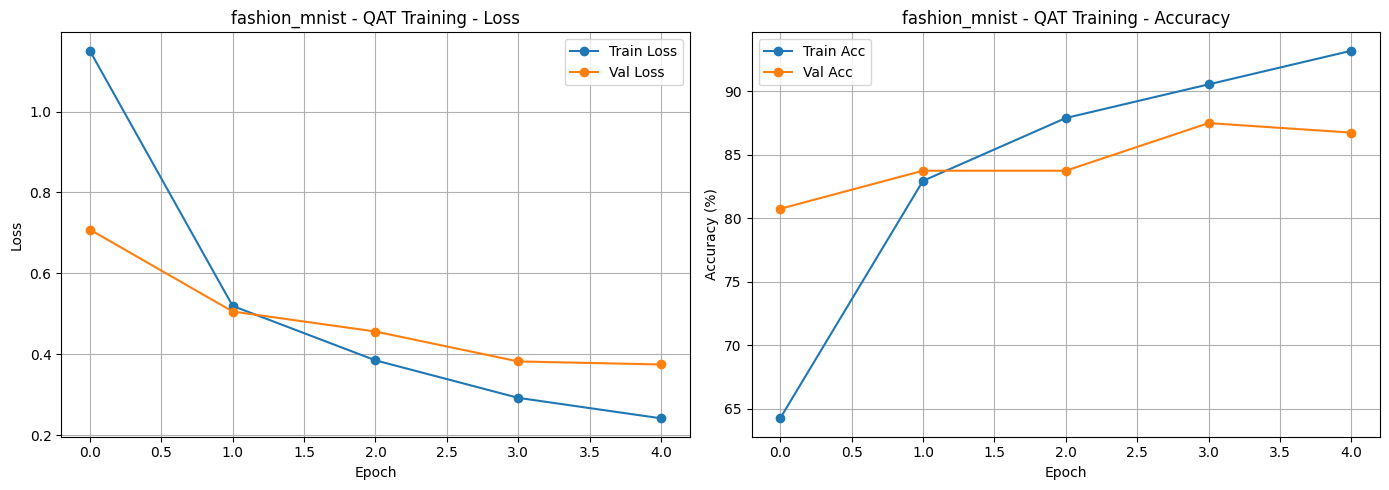


Benchmarking: QAT (INT8)
--------------------------------------------------
Model size: 10.79 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]

Accuracy: 84.25%


Inference time: 52.67 ± 17.94 ms/batch

--- Results Summary for fashion_mnist ---
          model_name   size_mb  accuracy  inference_time_ms  inference_std_ms
     Baseline (FP32) 42.728831     89.00         341.152520        110.736506
Dynamic Quant (INT8) 42.714978     89.00         344.403729        108.648651
  Static Quant (PTQ) 10.789887     89.00          54.948100         19.107829
          QAT (INT8) 10.789887     84.25          52.667284         17.936522


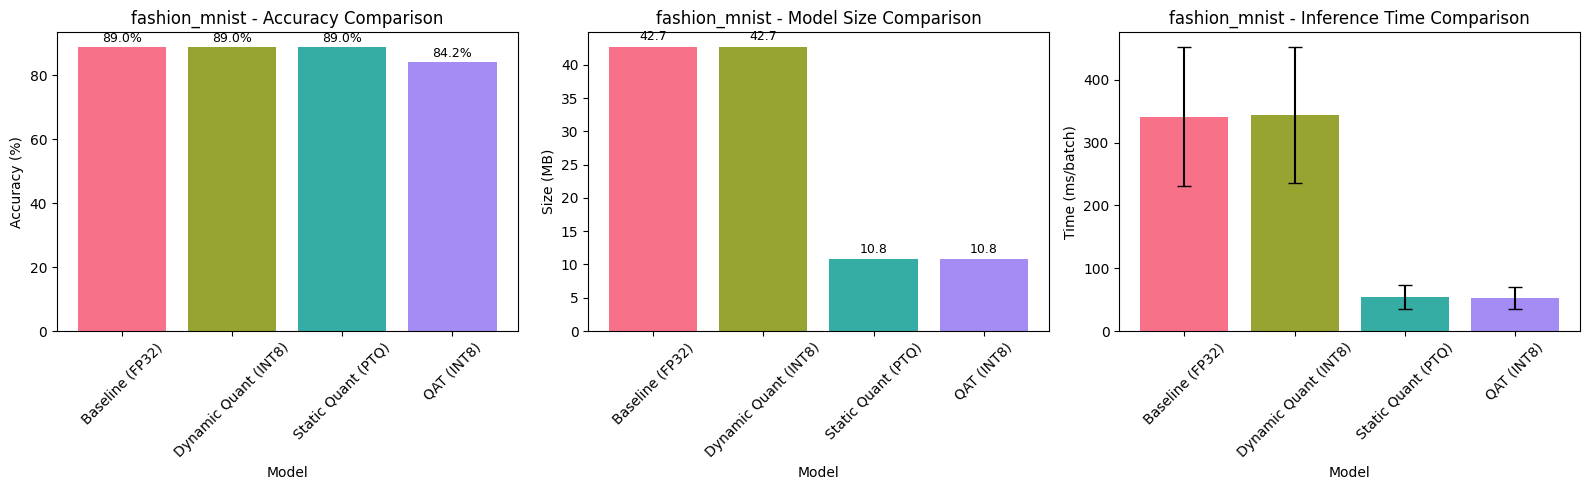


EXPERIMENT: CIFAR100
Dataset: cifar100
  Train samples: 2000
  Test samples: 400
  Calibration samples: 1000

--- Step 1: Training Baseline ResNet18 ---
Loading pre-trained model from ./models/cifar100_resnet18_baseline.pt

Benchmarking: Baseline (FP32)
--------------------------------------------------
Model size: 42.90 MB
Dataset: cifar100
  Train samples: 2000
  Test samples: 400
  Calibration samples: 1000

--- Step 1: Training Baseline ResNet18 ---
Loading pre-trained model from ./models/cifar100_resnet18_baseline.pt

Benchmarking: Baseline (FP32)
--------------------------------------------------
Model size: 42.90 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

Accuracy: 43.00%


Inference time: 280.68 ± 110.14 ms/batch

--- Step 2: Dynamic Quantization ---

Benchmarking: Dynamic Quant (INT8)
--------------------------------------------------
Model size: 42.76 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

Accuracy: 43.00%


Inference time: 266.43 ± 90.86 ms/batch

--- Step 3: Static Quantization (PTQ) ---
Calibrating model...


Calibration: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]




Benchmarking: Static Quant (PTQ)
--------------------------------------------------
Model size: 10.84 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]

Accuracy: 43.75%


Inference time: 52.32 ± 19.70 ms/batch

--- Step 4: Quantization-Aware Training ---


QAT Epoch 1/5: 100%|██████████| 32/32 [00:46<00:00,  1.45s/it, loss=0.0710, acc=5.40%]


QAT Epoch 1: Train Acc=5.40%, Val Acc=15.25%


QAT Epoch 2/5: 100%|██████████| 32/32 [00:45<00:00,  1.44s/it, loss=0.0557, acc=32.00%]


QAT Epoch 2: Train Acc=32.00%, Val Acc=25.00%


QAT Epoch 3/5: 100%|██████████| 32/32 [00:44<00:00,  1.40s/it, loss=0.0452, acc=48.20%]


QAT Epoch 3: Train Acc=48.20%, Val Acc=35.75%


QAT Epoch 4/5: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it, loss=0.0373, acc=61.95%]


QAT Epoch 4: Train Acc=61.95%, Val Acc=40.75%


QAT Epoch 5/5: 100%|██████████| 32/32 [00:44<00:00,  1.38s/it, loss=0.0305, acc=70.40%]



QAT Epoch 5: Train Acc=70.40%, Val Acc=44.50%


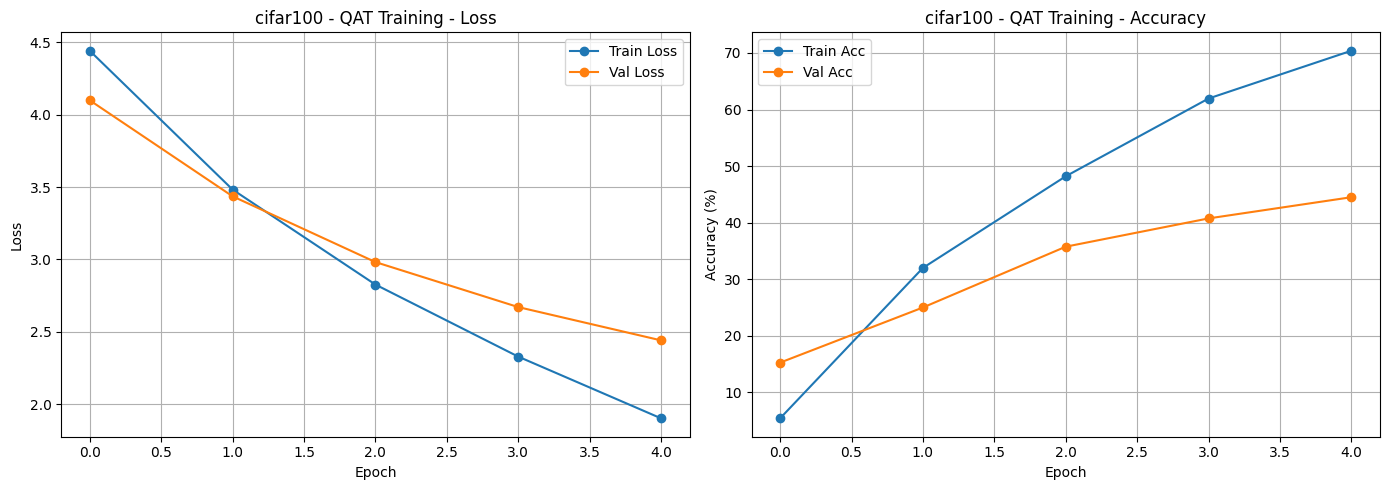


Benchmarking: QAT (INT8)
--------------------------------------------------
Model size: 10.84 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  9.84it/s]

Accuracy: 45.25%


Inference time: 51.79 ± 19.75 ms/batch

--- Results Summary for cifar100 ---
          model_name   size_mb  accuracy  inference_time_ms  inference_std_ms
     Baseline (FP32) 42.904979     43.00         280.682542        110.135450
Dynamic Quant (INT8) 42.759290     43.00         266.433874         90.863387
  Static Quant (PTQ) 10.835542     43.75          52.318548         19.697391
          QAT (INT8) 10.835542     45.25          51.789330         19.748344


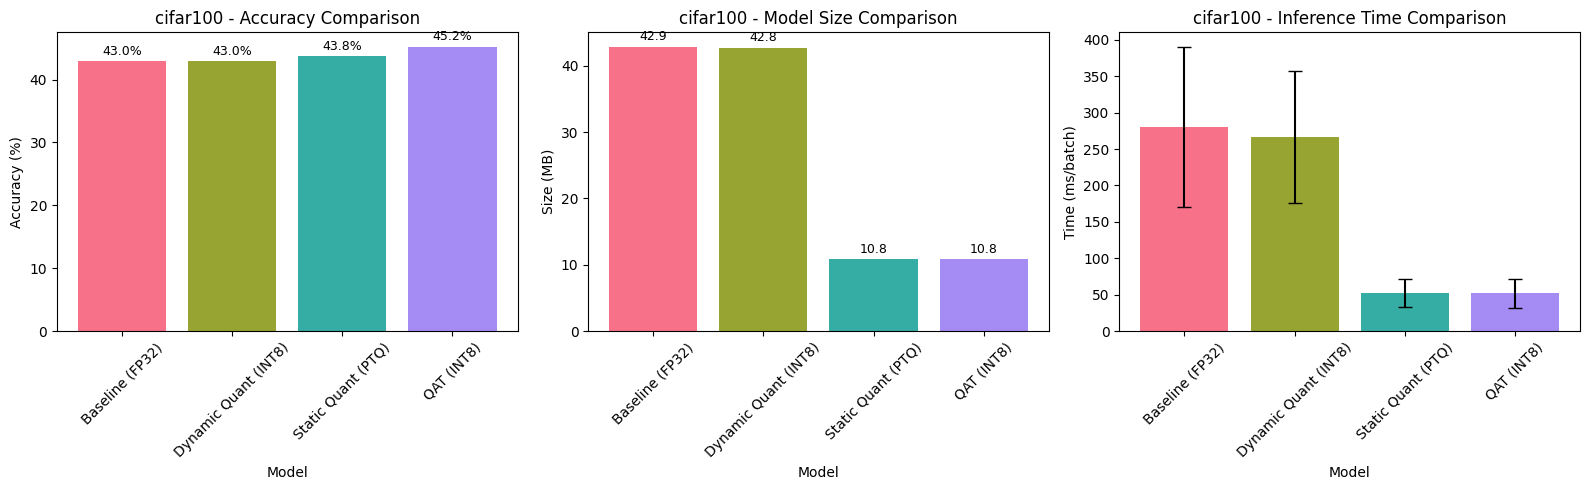


EXPERIMENT: FOOD101


100%|██████████| 5.00G/5.00G [03:31<00:00, 23.7MB/s]  



Dataset: food101
  Train samples: 2000
  Test samples: 400
  Calibration samples: 1000

--- Step 1: Training Baseline ResNet18 ---


Epoch 1/10: 100%|██████████| 32/32 [00:28<00:00,  1.13it/s, loss=0.0686, acc=8.50%]


Epoch 1: Train Loss=4.2859, Train Acc=8.50%, Val Loss=4.6740, Val Acc=9.00%


Epoch 2/10: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s, loss=0.0511, acc=23.65%]



Epoch 2: Train Loss=3.1933, Train Acc=23.65%, Val Loss=3.7226, Val Acc=15.50%


Epoch 3/10: 100%|██████████| 32/32 [00:28<00:00,  1.14it/s, loss=0.0405, acc=36.40%]


Epoch 3: Train Loss=2.5321, Train Acc=36.40%, Val Loss=4.1700, Val Acc=20.50%


Epoch 4/10: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s, loss=0.0314, acc=50.80%]


Epoch 4: Train Loss=1.9640, Train Acc=50.80%, Val Loss=3.1914, Val Acc=26.25%


Epoch 5/10: 100%|██████████| 32/32 [00:27<00:00,  1.14it/s, loss=0.0234, acc=65.60%]


Epoch 5: Train Loss=1.4632, Train Acc=65.60%, Val Loss=3.1657, Val Acc=27.00%


Epoch 6/10: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s, loss=0.0130, acc=84.85%]


Epoch 6: Train Loss=0.8143, Train Acc=84.85%, Val Loss=2.4917, Val Acc=38.75%


Epoch 7/10: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s, loss=0.0086, acc=93.00%]


Epoch 7: Train Loss=0.5395, Train Acc=93.00%, Val Loss=2.4442, Val Acc=40.50%


Epoch 8/10: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s, loss=0.0067, acc=95.55%]


Epoch 8: Train Loss=0.4204, Train Acc=95.55%, Val Loss=2.4484, Val Acc=40.75%


Epoch 9/10: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s, loss=0.0059, acc=96.55%]


Epoch 9: Train Loss=0.3693, Train Acc=96.55%, Val Loss=2.4642, Val Acc=39.75%


Epoch 10/10: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s, loss=0.0049, acc=97.70%]



Epoch 10: Train Loss=0.3056, Train Acc=97.70%, Val Loss=2.4485, Val Acc=40.75%
Model saved to ./models/food101_resnet18_baseline.pt


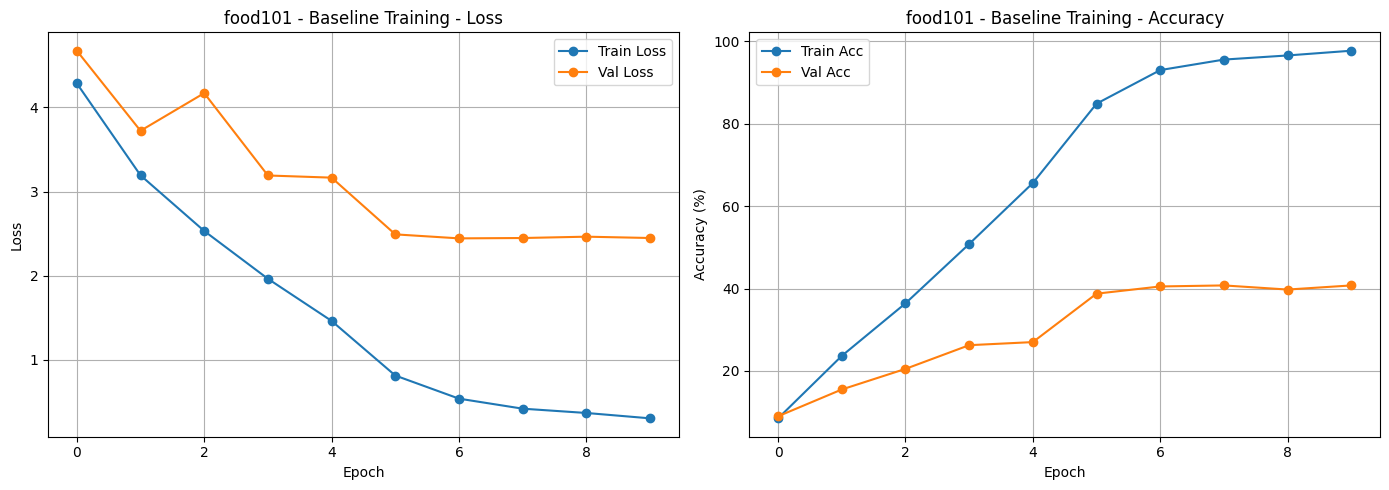


Benchmarking: Baseline (FP32)
--------------------------------------------------
Model size: 42.91 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

Accuracy: 40.75%


Inference time: 258.50 ± 86.80 ms/batch

--- Step 2: Dynamic Quantization ---

Benchmarking: Dynamic Quant (INT8)
--------------------------------------------------
Model size: 42.76 MB


Evaluating: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

Accuracy: 41.00%


Inference time: 259.02 ± 87.58 ms/batch

--- Step 3: Static Quantization (PTQ) ---
Calibrating model...


Calibration: 100%|██████████| 16/16 [00:07<00:00,  2.00it/s]




Benchmarking: Static Quant (PTQ)
--------------------------------------------------
Model size: 10.84 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]

Accuracy: 40.25%


Inference time: 63.88 ± 26.46 ms/batch

--- Step 4: Quantization-Aware Training ---


QAT Epoch 1/5: 100%|██████████| 32/32 [00:45<00:00,  1.43s/it, loss=0.0726, acc=5.15%]


QAT Epoch 1: Train Acc=5.15%, Val Acc=11.00%


QAT Epoch 2/5: 100%|██████████| 32/32 [00:44<00:00,  1.39s/it, loss=0.0584, acc=31.50%]


QAT Epoch 2: Train Acc=31.50%, Val Acc=22.00%


QAT Epoch 3/5: 100%|██████████| 32/32 [00:44<00:00,  1.41s/it, loss=0.0492, acc=48.00%]


QAT Epoch 3: Train Acc=48.00%, Val Acc=32.50%


QAT Epoch 4/5: 100%|██████████| 32/32 [00:43<00:00,  1.37s/it, loss=0.0413, acc=63.80%]



QAT Epoch 4: Train Acc=63.80%, Val Acc=38.25%


QAT Epoch 5/5: 100%|██████████| 32/32 [00:43<00:00,  1.36s/it, loss=0.0348, acc=73.80%]


QAT Epoch 5: Train Acc=73.80%, Val Acc=40.25%


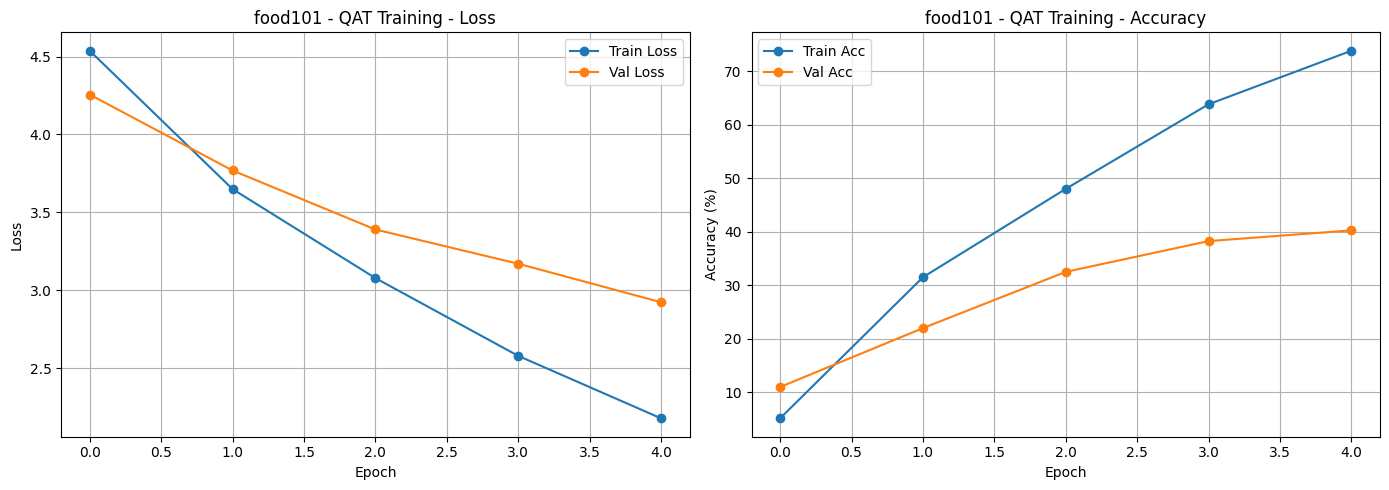


Benchmarking: QAT (INT8)
--------------------------------------------------
Model size: 10.84 MB


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]

Accuracy: 39.25%


Inference time: 59.16 ± 27.58 ms/batch

--- Results Summary for food101 ---
          model_name   size_mb  accuracy  inference_time_ms  inference_std_ms
     Baseline (FP32) 42.906932     40.75         258.498451         86.795920
Dynamic Quant (INT8) 42.759778     41.00         259.016328         87.579275
  Static Quant (PTQ) 10.836030     40.25          63.875908         26.463241
          QAT (INT8) 10.836030     39.25          59.164108         27.575628


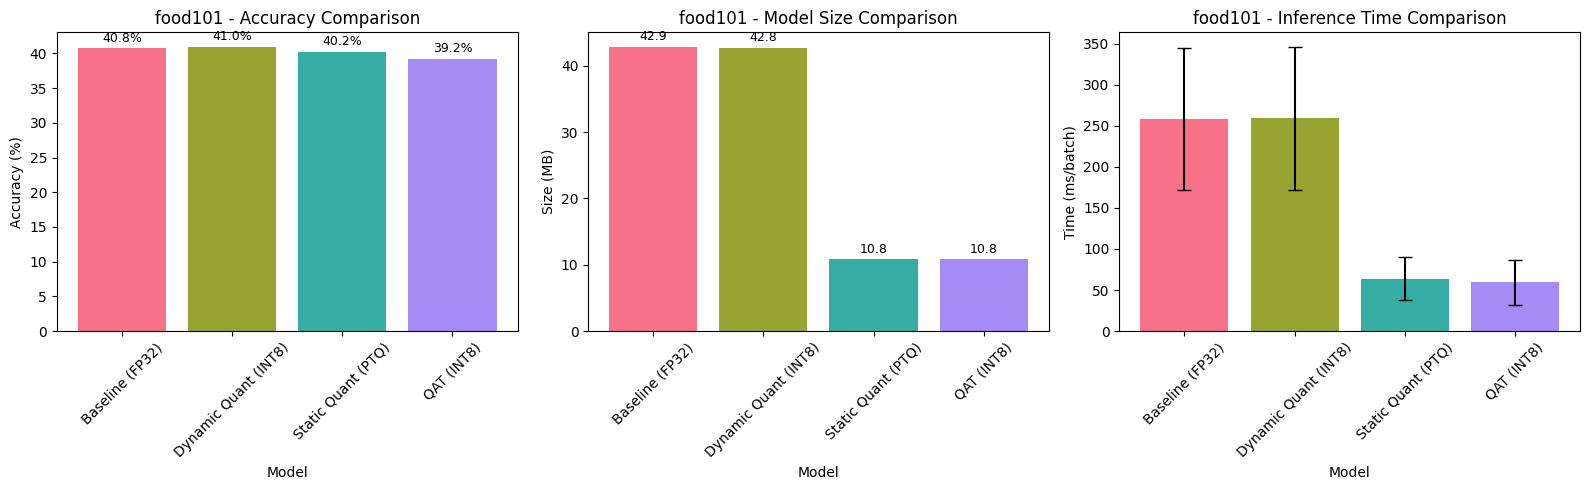


EXPERIMENT: STANFORD_CARS
Stanford Cars download may have issues. Error: The original URL is broken so the StanfordCars dataset cannot be downloaded anymore.
You may need to download it manually from Kaggle.
Skipping stanford_cars - dataset loading failed

ALL EXPERIMENTS COMPLETED


In [ ]:
# Store all results
all_results = {}

# List of datasets to run experiments on
datasets_to_run = ['cifar100', 'fashion_mnist', 'food101', 'stanford_cars']

# Run experiments for each dataset
# Note: Set subset_size for faster runs, or None for full dataset
# Note: Set skip_qat=True to skip QAT (slower but gives best quantized results)

for dataset_name in datasets_to_run:
    try:
        results = run_experiment_for_dataset(
            dataset_name,
            subset_size=5000,  # Use 5000 samples for faster runs; set to None for full
            skip_qat=False     # Set to True to skip QAT
        )
        if results is not None:
            all_results[dataset_name] = results
    except Exception as e:
        print(f"Error running experiment for {dataset_name}: {e}")
        continue

print("\n" + "="*60)
print("ALL EXPERIMENTS COMPLETED")
print("="*60)

## 10. Final Analysis and Comparison

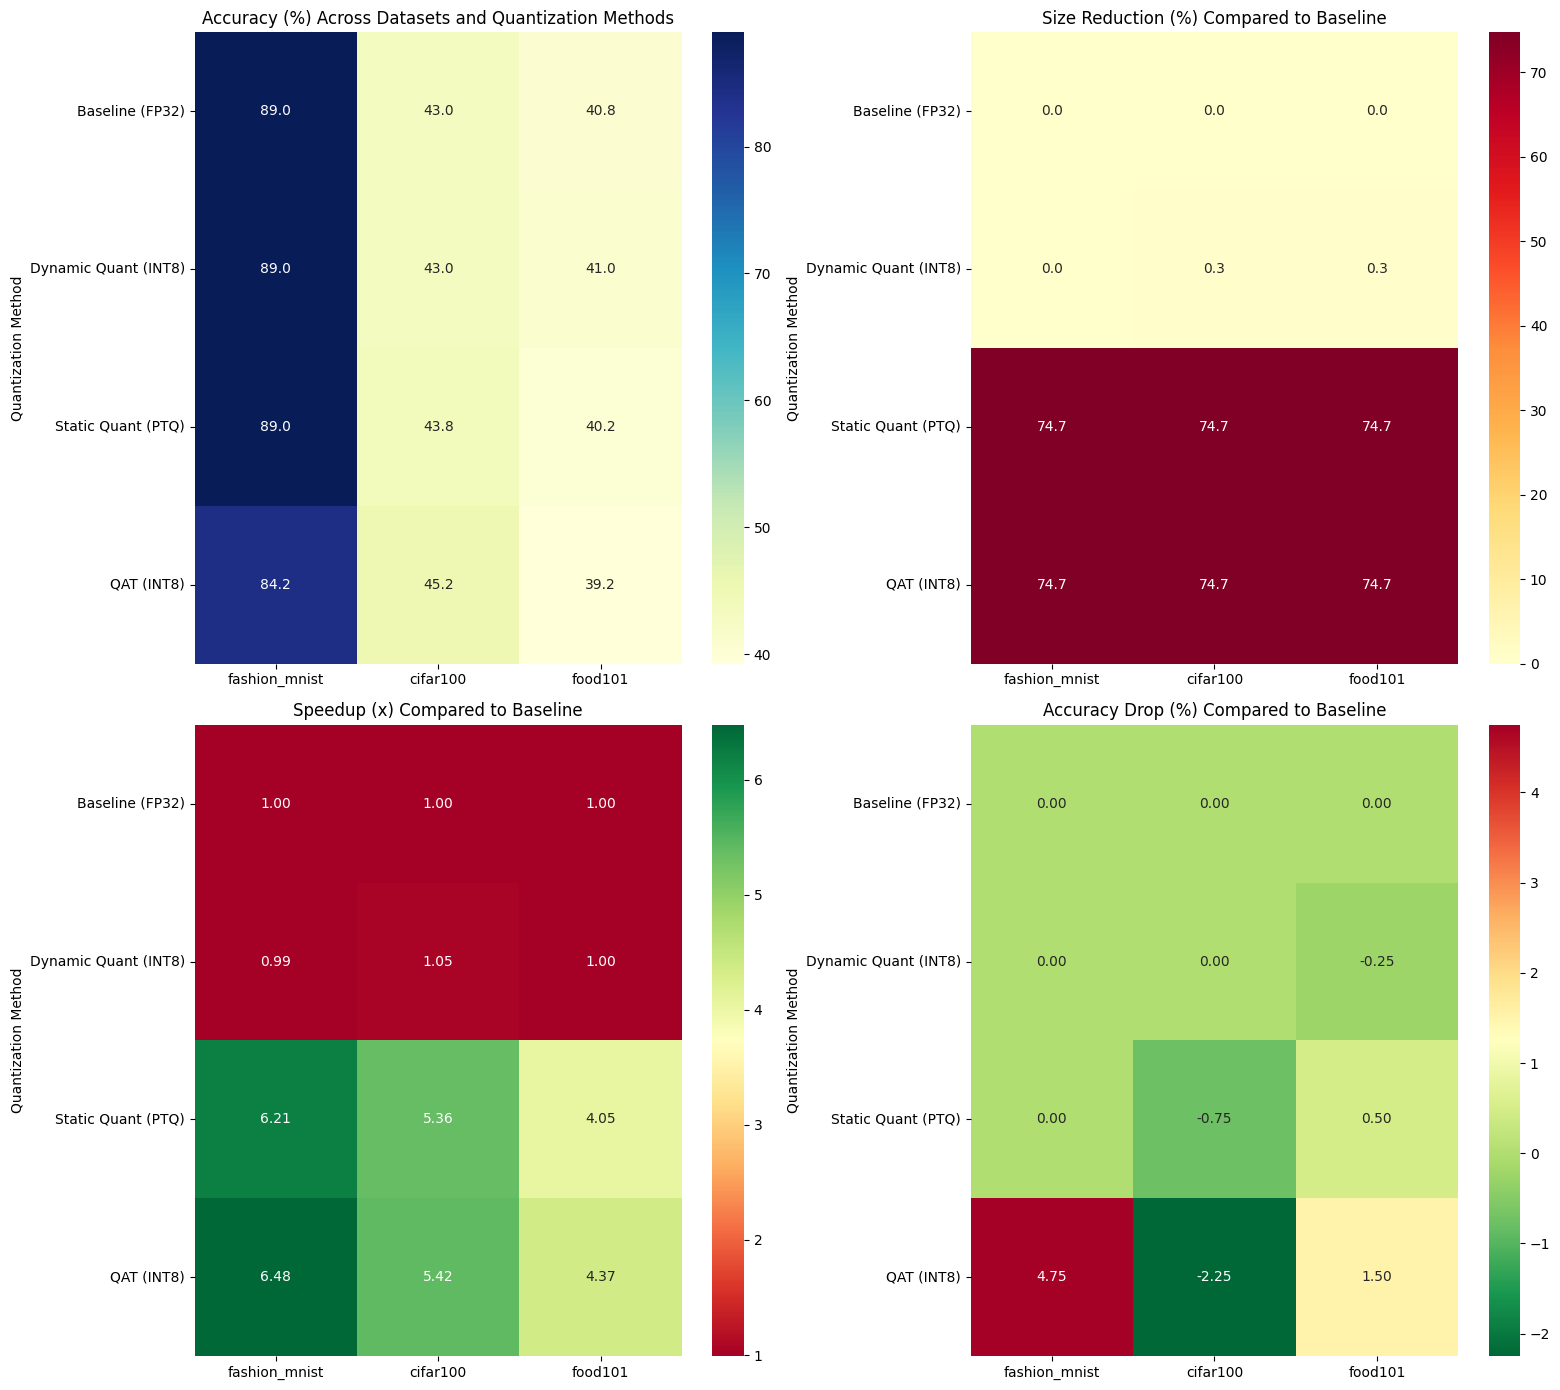

In [22]:
# Plot comprehensive comparison across all datasets
if len(all_results) > 0:
    plot_all_datasets_comparison(all_results)
else:
    print("No results to plot. Run the experiments first.")